In [1]:
import pickle as pkl
import time
import os
import numpy as np
import sys
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from music21 import instrument, note, stream, chord, duration
from RNNAttention import RNNAttention

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


### 파라미터

In [3]:
intervals = range(1)
seq_len = 32
embed_size = 100
rnn_units = 256
batch_size = 32
use_attention = True

data_folder = '../data/cello'
output_folder = './output/lstm_compose'
image_save_folder = './images/lstm_compose'
store_folder = './store'
model_save_path = './lstm_compose.pth'

os.makedirs(output_folder, exist_ok=True)

### 룩업 테이블 적재

In [4]:
with open(os.path.join(store_folder, 'distincts'), 'rb') as filepath:
    distincts = pkl.load(filepath)
    note_names, n_notes, duration_names, n_durations = distincts
    
with open(os.path.join(store_folder, 'lookups'), 'rb') as filepath:
    lookups = pkl.load(filepath)
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

### 모델 만들기

In [5]:
model = RNNAttention(n_notes, n_durations, embed_size, rnn_units, seq_len, use_attention)
model = model.to(device)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

RNNAttention(
  (embedding1): Embedding(474, 100)
  (embedding2): Embedding(19, 100)
  (lstm): LSTM(200, 256, batch_first=True)
  (layer1): Attention(
    (lstm): LSTM(256, 256, batch_first=True)
    (linear): Linear(in_features=256, out_features=1, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (linear1): Linear(in_features=256, out_features=474, bias=True)
  (linear2): Linear(in_features=256, out_features=19, bias=True)
)

### 자신만의 악절 만들기

In [6]:
notes_temp = 0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

# notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]


# notes = ['START', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3','F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + duration_names
    
sequence_length = len(notes)

### 악보 시퀀스를 기반으로 신경망에서 악보 생성하기

In [7]:
def sample_with_temp(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [8]:
num_input_notes = len(notes)
prediction_output = []
notes_input_sequence = torch.zeros(num_input_notes, dtype=torch.int64).to(device)
durations_input_sequence = torch.zeros(num_input_notes, dtype=torch.int64).to(device)

overall_preds = []

for i, (n, d) in enumerate(zip(notes, durations)):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]
    
    notes_input_sequence[i] = note_int
    durations_input_sequence[i] = duration_int
    
    prediction_output.append([n, d])
    
    if n != 'START':
        midi_note = note.Note(n)
        
        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)
        
att_matrix = np.zeros(shape = (max_extra_notes + sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):
    prediction_input = [
        notes_input_sequence.unsqueeze(0)
        , durations_input_sequence.unsqueeze(0)
    ]
    
    with torch.no_grad():
        [notes_prediction, durations_prediction], att_prediction = model(prediction_input)
        notes_prediction = F.softmax(notes_prediction[0], dim=0)
        durations_prediction = F.softmax(durations_prediction[0], dim=0)
    if use_attention:
        att_matrix[(note_index - att_prediction.size(1) + sequence_length):(note_index + sequence_length), note_index] = att_prediction[0].detach().numpy()
        
    new_note = np.zeros(128)
    
    for idx, n_i in enumerate(notes_prediction):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i

        except:
            pass
        
        overall_preds.append(new_note)

    i1 = sample_with_temp(notes_prediction.detach().numpy(), notes_temp)
    i2 = sample_with_temp(durations_prediction.detach().numpy(), duration_temp)
    
    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]
    
    prediction_output.append([note_result, duration_result])
    
    notes_input_sequence = torch.cat([notes_input_sequence, torch.IntTensor([i1])], dim=0)
    durations_input_sequence = torch.cat([durations_input_sequence, torch.IntTensor([i2])], dim=0)
    
    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]
        
    if note_result == 'START':
        break
    
overall_preds = np.transpose(np.array(overall_preds))
print('Generated sequence of {} notes'.format(len(prediction_output)))

Generated sequence of 82 notes


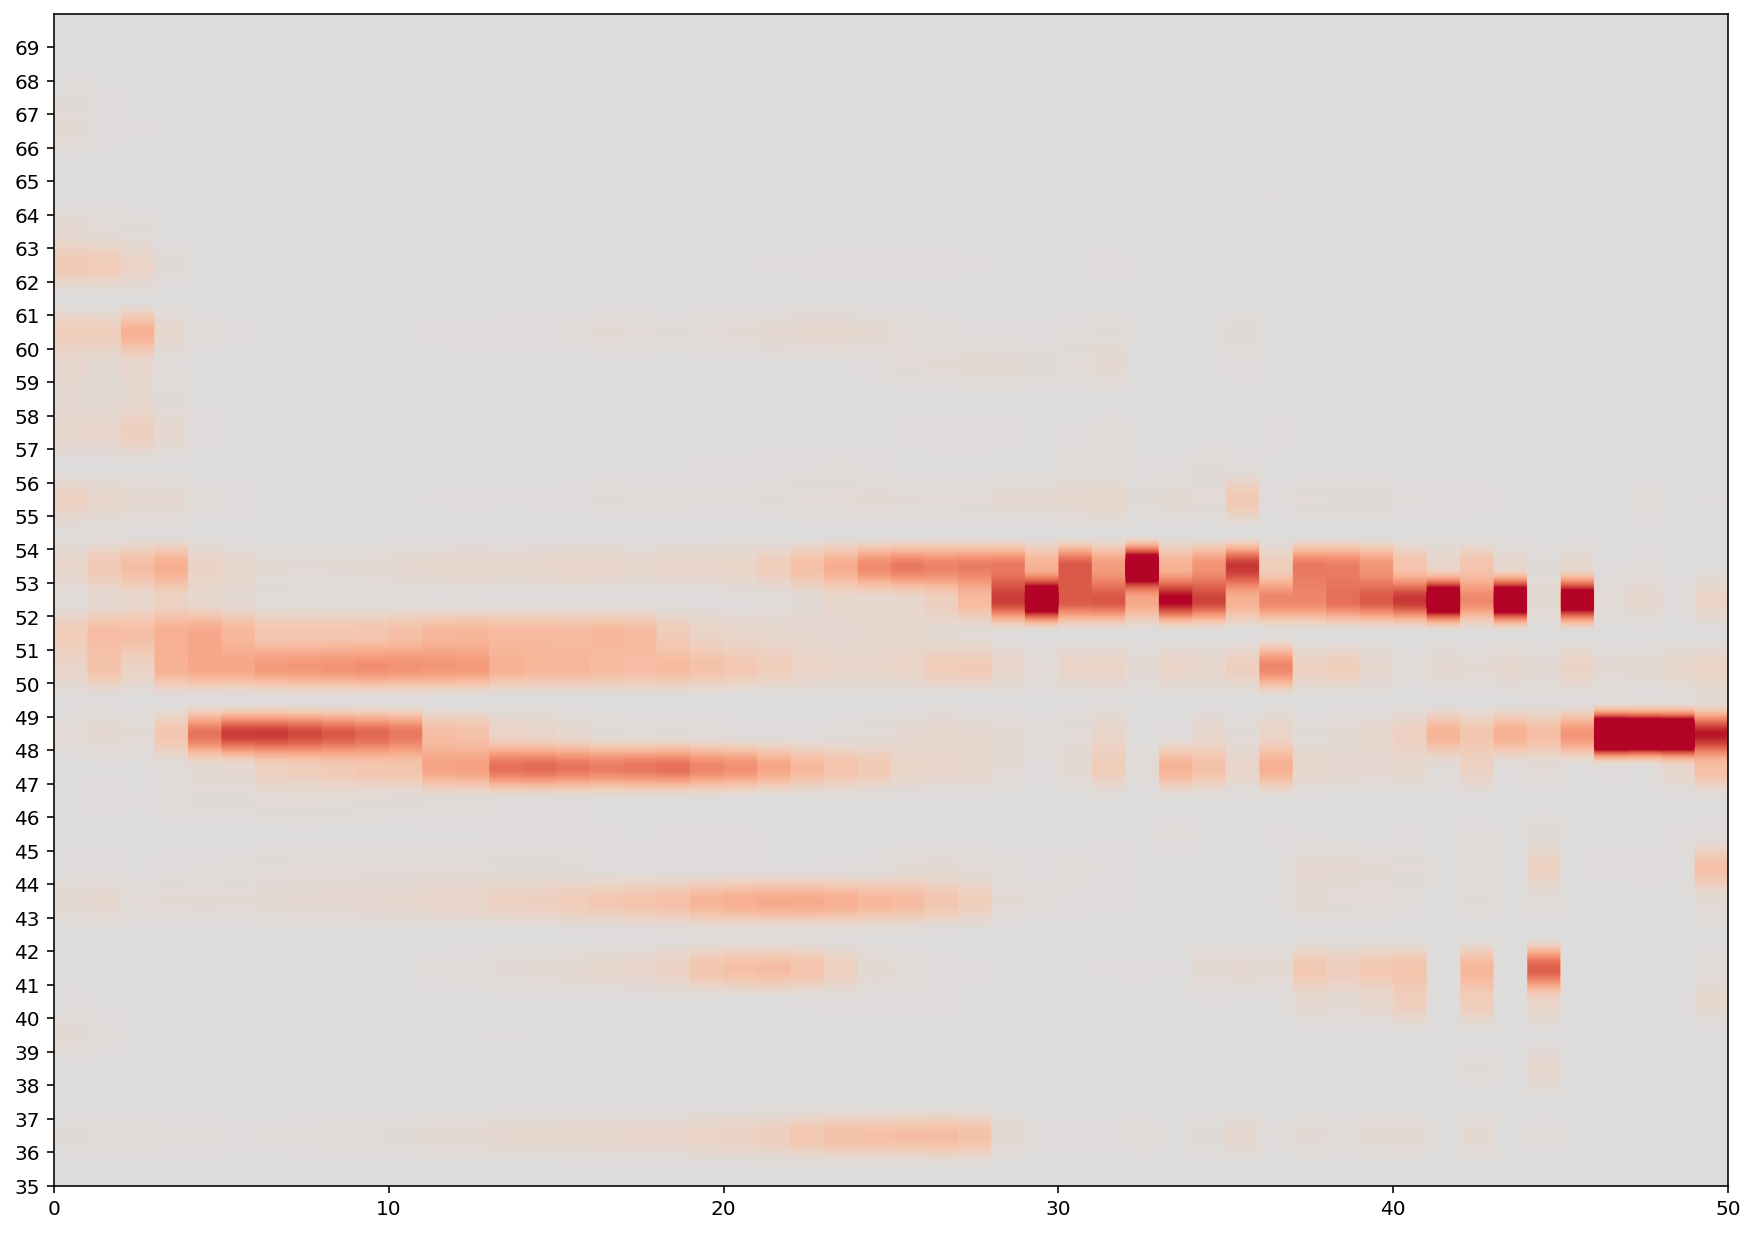

In [9]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_yticks([int(j) for j in range(35, 70)])

plt.imshow(overall_preds[35:70, :], origin="lower", cmap='coolwarm', vmin=-0.5, vmax=0.5, extent=[0, max_extra_notes, 35, 70])
plt.savefig(os.path.join(image_save_folder, "Probability distribution of the next note.png"))

### 예측 출력을 악보로 변환하고 악보에서 미디 파일 만들기

In [10]:
midi_stream = stream.Stream()

for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
        
midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(output_folder, 'output-' + timestr + '.mid'))

'./output/lstm_compose\\output-20220909-114139.mid'

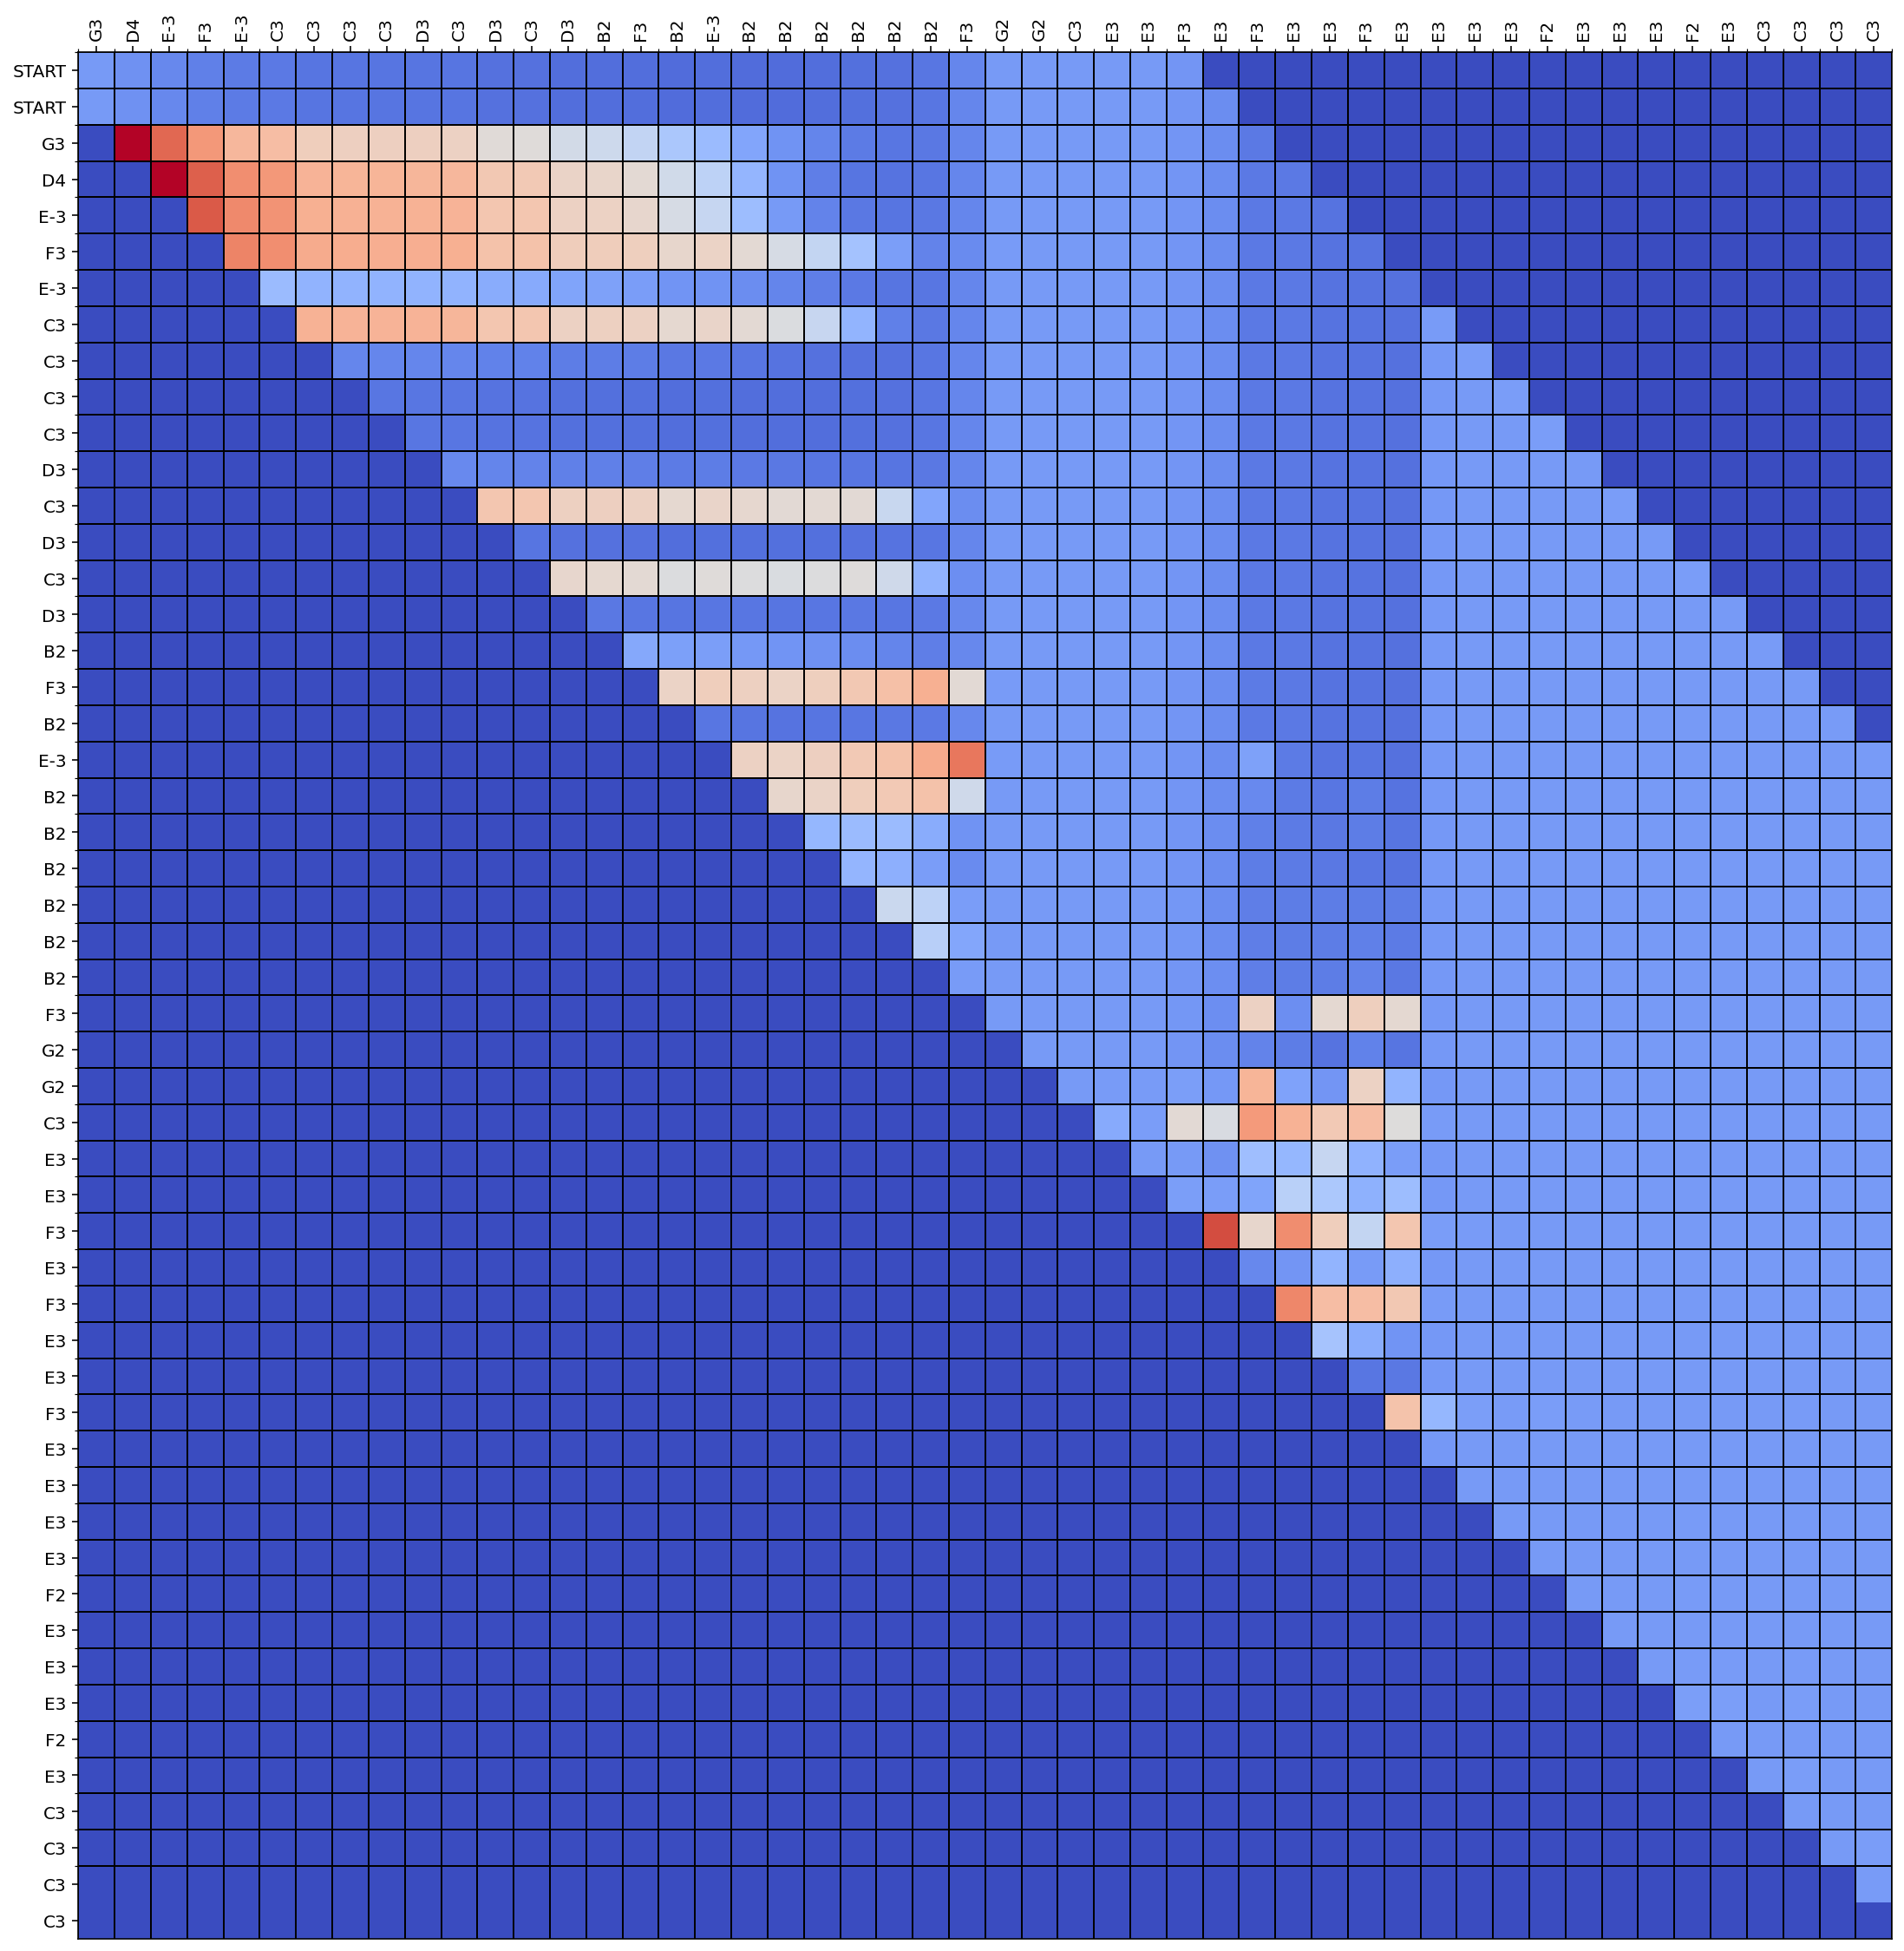

In [11]:
if use_attention:
    fix, ax = plt.subplots(figsize=(20, 20))
    
    im = ax.imshow(att_matrix[(seq_len-2):,], cmap='coolwarm', interpolation='nearest')
    
    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(prediction_output) - seq_len, 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(prediction_output) - seq_len, 1), minor=True)
    
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output) - seq_len + 2))
    
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])
    
    ax.xaxis.tick_top()
    
    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va="center", rotation_mode="anchor")
    plt.savefig(os.path.join(image_save_folder, "attention_map.png"))

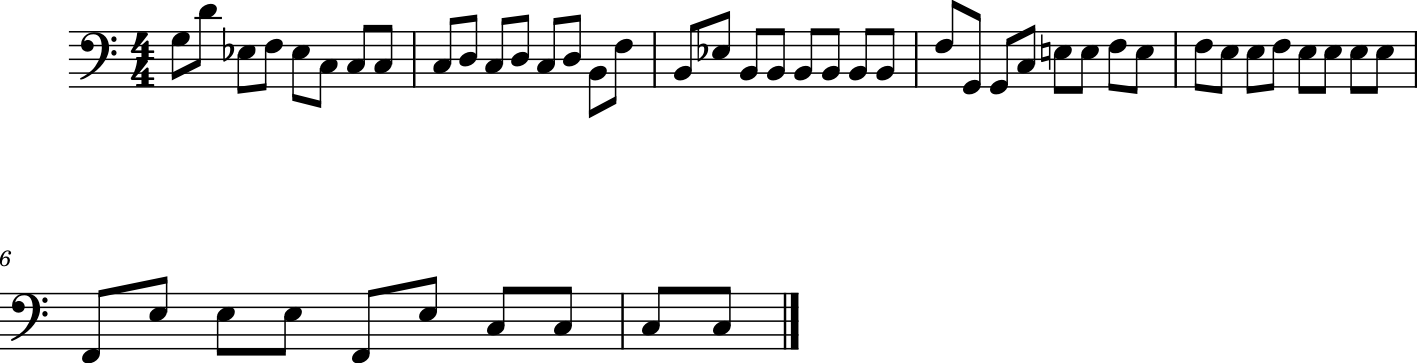

In [12]:
midi_stream.show()